<a href="https://colab.research.google.com/github/Dviteesha/Thesis-/blob/main/classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === PART 1: Load Data + Feature Selection + Preprocessing + Stratified Split (No Normalization) ===

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import entropy
import os

print("📥 Loading 4 gesture files (0.csv to 3.csv)...")

# Load and label all 4 files
def load_all_gesture_files():
    dataframes = []
    for i in range(4):
        df = pd.read_csv(f"{i}.csv", header=None)
        df['label'] = i  # Add gesture label
        dataframes.append(df)
    return pd.concat(dataframes, ignore_index=True)

df = load_all_gesture_files()
print(f"✅ Loaded {df.shape[0]} total samples across 4 gestures.")

# Drop rows with nulls
df.dropna(inplace=True)

# --- Select only the first reading for each of the 8 sensors from the 64 values ---
X_raw = df.iloc[:, :64]
X_selected = X_raw.iloc[:, [i for i in range(0, 64, 8)]]  # Columns: 0, 8, ..., 56
X_selected = X_selected.to_numpy()  # ✅ Ensure NumPy array
y = df['label'].to_numpy()          # ✅ Ensure NumPy array

print("🧠 Selected 1 reading per muscle (8 features per sample).")
print("🚫 Skipping normalization — using raw EMG signal values.")

# --- Sliding Window Feature Extraction ---
def extract_features(window):
    feats = []
    for i in range(window.shape[1]):
        signal = window[:, i]
        feats += [
            np.mean(signal), np.std(signal), np.max(signal), np.min(signal),
            np.sqrt(np.mean(signal**2)),  # RMS
            np.sum(np.abs(np.diff(signal))),  # Waveform length
            entropy(np.histogram(signal, bins=10)[0] + 1)
        ]
    return feats

def sliding_window_features(X, y, window_size=50, step_size=25):
    X_feat, y_feat = [], []
    for gesture in np.unique(y):
        gesture_data = X[y == gesture]
        for i in range(0, len(gesture_data) - window_size + 1, step_size):
            window = gesture_data[i:i+window_size]
            X_feat.append(extract_features(window))
            y_feat.append(gesture)
    return np.array(X_feat), np.array(y_feat)

X_feat, y_feat = sliding_window_features(X_selected, y)
print(f"🪟 Sliding window segmentation completed. Feature shape: {X_feat.shape}")

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_feat, y_feat, test_size=0.2, stratify=y_feat, random_state=42
)

print(f"✅ Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}\n")


📥 Loading 4 gesture files (0.csv to 3.csv)...
✅ Loaded 11678 total samples across 4 gestures.
🧠 Selected 1 reading per muscle (8 features per sample).
🚫 Skipping normalization — using raw EMG signal values.
🪟 Sliding window segmentation completed. Feature shape: (461, 56)
✅ Training samples: 368, Testing samples: 93



In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import random

def get_reward(y_pred, y_true, p_plus, p_minus):
    return p_plus if y_pred != y_true else -p_minus

def roar_algorithm(X, y, theta=0.9, epsilon=0.05, eta=0.05, p_plus=0.5, p_minus=2, budget=100):
    clf = RandomForestClassifier()
    X_train, y_train = [], []
    predictions = []
    reward_list = []
    n_queries = 0

    print("🚀 Starting ROAR training loop...\n")

    for i in range(len(X)):
        x = X[i].reshape(1, -1)
        true_label = y[i]

        if len(X_train) == 0:
            X_train.append(x[0])
            y_train.append(true_label)
            clf.fit(X_train, y_train)
            predictions.append(true_label)
            n_queries += 1
            continue

        proba = clf.predict_proba(x)[0]
        confidence = np.max(proba)
        y_pred = np.argmax(proba)
        r = random.random()

        query = r < epsilon or confidence < theta

        if query and n_queries < budget:
            X_train.append(x[0])
            y_train.append(true_label)
            clf.fit(X_train, y_train)
            reward = get_reward(y_pred, true_label, p_plus, p_minus)
            theta = min(theta * (1 + eta * (1 - 2 * reward / p_minus)), 1)
            reward_list.append(reward)
            predictions.append(true_label)
            n_queries += 1
        else:
            predictions.append(y_pred)

    print(f"📈 ROAR training done. Labels queried: {n_queries}\n")
    return predictions, n_queries, reward_list


🚀 Starting ROAR training loop...

📈 ROAR training done. Labels queried: 300

🎯 ROAR Test Set Evaluation Summary
✔️ Test Accuracy: 0.8387 (means ~83.9% correct predictions)
📊 Macro F1 Score: 0.8372 (balanced across 4 gesture classes)
🔍 Queried Labels from Oracle: 300 out of 368 training samples


<Figure size 600x500 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


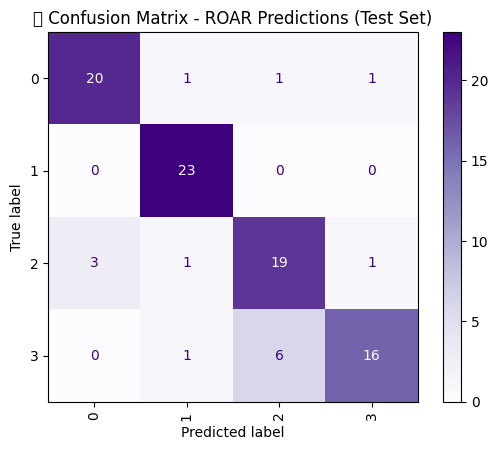

In [4]:
# Run ROAR
preds_train, queries_used, rewards = roar_algorithm(X_train, y_train, budget=300)

# Evaluate on test set
clf_eval = RandomForestClassifier()
clf_eval.fit(X_train, y_train)
y_pred_test = clf_eval.predict(X_test)

acc = accuracy_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test, average='macro')

print("🎯 ROAR Test Set Evaluation Summary")
print(f"✔️ Test Accuracy: {acc:.4f} (means ~{acc*100:.1f}% correct predictions)")
print(f"📊 Macro F1 Score: {f1:.4f} (balanced across 4 gesture classes)")
print(f"🔍 Queried Labels from Oracle: {queries_used} out of {len(X_train)} training samples")

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(6, 5))
disp.plot(cmap='Purples', xticks_rotation='vertical')
plt.title("🧾 Confusion Matrix - ROAR Predictions (Test Set)")
plt.grid(False)
plt.show()


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def run_baseline(X_train, y_train, X_test, y_test):
    print("\n🏁 Running Baseline: Fully Supervised Random Forest")
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"✅ Baseline Accuracy: {acc:.4f}")
    print(f"📊 Baseline Macro F1 Score: {f1:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure(figsize=(6, 5))
    disp.plot(cmap='Greens')
    plt.title("🧾 Confusion Matrix - Baseline Model")
    plt.grid(False)
    plt.show()

    return acc, f1


In [6]:
import random

def run_random_sampling(X_train, y_train, X_test, y_test, budget=100):
    print(f"\n🎲 Running Random Sampling Strategy (budget = {budget})")

    indices = list(range(len(X_train)))
    random.shuffle(indices)
    queried_idx = indices[:budget]

    X_sampled = X_train[queried_idx]
    y_sampled = y_train[queried_idx]

    clf = RandomForestClassifier()
    clf.fit(X_sampled, y_sampled)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"✅ Random Sampling Accuracy: {acc:.4f}")
    print(f"📊 Random Sampling Macro F1 Score: {f1:.4f}")
    print(f"🔍 Queried Labels: {len(y_sampled)}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure(figsize=(6, 5))
    disp.plot(cmap='Oranges')
    plt.title("🧾 Confusion Matrix - Random Sampling")
    plt.grid(False)
    plt.show()

    return acc, f1



🏁 Running Baseline: Fully Supervised Random Forest
✅ Baseline Accuracy: 0.8495
📊 Baseline Macro F1 Score: 0.8508


<Figure size 600x500 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


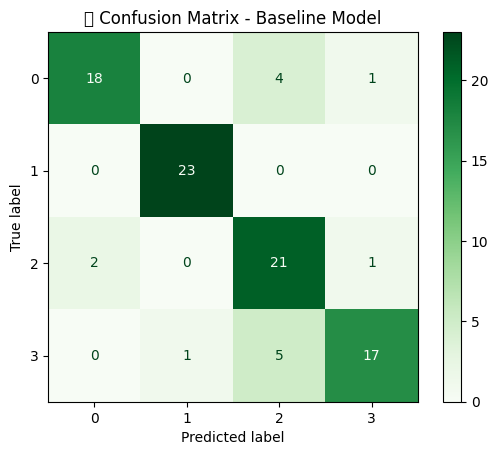


🎲 Running Random Sampling Strategy (budget = 100)
✅ Random Sampling Accuracy: 0.7634
📊 Random Sampling Macro F1 Score: 0.7442
🔍 Queried Labels: 100


<Figure size 600x500 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


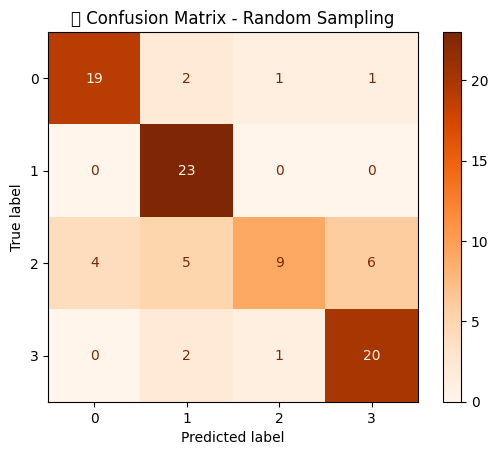


🔍 Summary Comparison:
Baseline (Full Supervised):  Acc = 0.8495, F1 = 0.8508
Random Sampling (100 labels): Acc = 0.7634, F1 = 0.7442
ROAR (100 labels):            Acc = 0.8387, F1 = 0.8372


In [7]:
# Run Baseline
baseline_acc, baseline_f1 = run_baseline(X_train, y_train, X_test, y_test)

# Run Random Sampling
random_acc, random_f1 = run_random_sampling(X_train, y_train, X_test, y_test, budget=100)

# ROAR already run previously:
# preds_train, queries_used, rewards = roar_algorithm(...)
# clf_eval = RandomForestClassifier().fit(X_train_ROAR, y_train_ROAR)
# y_pred_test = clf_eval.predict(X_test)
# -> compute accuracy + f1 + confusion matrix

# Compare summary (optional)
print("\n🔍 Summary Comparison:")
print(f"Baseline (Full Supervised):  Acc = {baseline_acc:.4f}, F1 = {baseline_f1:.4f}")
print(f"Random Sampling (100 labels): Acc = {random_acc:.4f}, F1 = {random_f1:.4f}")
print(f"ROAR (100 labels):            Acc = {acc:.4f}, F1 = {f1:.4f}")
